In [1]:
#super basic Graph Classification on MUTAG
#MUTAG is a collection of static graphs representing chemical compounds with 
#each graph associated with a binary label.
#trying out some graph classification due to lack of node labels

import pandas as pd
import numpy as np

import stellargraph as sg
from stellargraph.mapper import PaddedGraphGenerator
from stellargraph.layer import GCNSupervisedGraphClassification
from stellargraph import StellarGraph

from stellargraph import datasets

from sklearn import model_selection
from IPython.display import display, HTML

from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
dataset = datasets.MUTAG()
display(HTML(dataset.description))
graphs, graph_labels = dataset.load()

In [3]:
#each graph is a stellargraph object
print(graphs[0].info())
print(graphs[1].info())

StellarGraph: Undirected multigraph
 Nodes: 17, Edges: 38

 Node types:
  default: [17]
    Features: float32 vector, length 7
    Edge types: default-default->default

 Edge types:
    default-default->default: [38]
        Weights: all 1 (default)
        Features: none
StellarGraph: Undirected multigraph
 Nodes: 13, Edges: 28

 Node types:
  default: [13]
    Features: float32 vector, length 7
    Edge types: default-default->default

 Edge types:
    default-default->default: [28]
        Weights: all 1 (default)
        Features: none


In [4]:
summary = pd.DataFrame([
    (g.number_of_nodes(), g.number_of_edges()) for g in graphs],
    columns=["nodes", "edges"])
summary.describe().round(1)

,nodes,edges
count,188.0,188.0
mean,17.9,39.6
std,4.6,11.4
min,10.0,20.0
25%,14.0,28.0
50%,17.5,38.0
75%,22.0,50.0
max,28.0,66.0


In [5]:
graph_labels.value_counts().to_frame()
#make labels 0, 1
graph_labels = pd.get_dummies(graph_labels, drop_first=True)

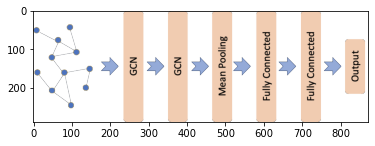

In [6]:
#The graph convolutional classification model 
#architecture is based on the one proposed in
#Fake News Detection on Social Media using Geometric Deep Learning, F. Monti, F. Frasca, D. Eynard, D. Mannion, and M. M. Bronstein, ICLR 2019.
#and applied on MUTAG in An End-to-End Deep Learning Architecture for Graph Classification, M. Zhang, Z. Cui, M. Neumann, Y. Chen, AAAI-18.

from PIL import Image
import requests
import matplotlib.pyplot as plt

url = "https://stellargraph.readthedocs.io/en/stable/_images/graph_classification_architecture.png"
response = requests.get(url, stream=True)
img = Image.open(response.raw)

#The first two layers are Graph Convolutional 
#with each layer having 64 units and relu activations. 
#The next layer is a mean pooling layer where the learned node 
#representation are summarized to create a graph representation. 
#The graph representation is input to two fully connected layers 
#with 32 and 16 units respectively and relu activations. 
#The last layer is the output layer with a single unit and 
#sigmoid activation.

plt.imshow(img)
plt.show()

In [7]:
generator = PaddedGraphGenerator(graphs)
def create_model(generator):
    
    gc_model = GCNSupervisedGraphClassification(
    layer_sizes=[64,64], activations=["relu", "relu"],
    generator=generator, dropout=0.5)
    
    x_in, x_out = gc_model.in_out_tensors()
    whole_graph_predictions = Dense(units=32, activation="relu")(x_out)
    whole_graph_predictions = Dense(units=16, activation="relu")(whole_graph_predictions)
    whole_graph_predictions = Dense(units=1, activation="sigmoid")(whole_graph_predictions)
    
    #Keras model
    model = Model(inputs = x_in, outputs = whole_graph_predictions)
    model.compile(optimizer=Adam(0.005), loss=binary_crossentropy, metrics=["acc"])
    
    return model

In [8]:
#do repeated cv 
epochs = 200
folds = 10
n_repeats = 5
#do early stopping 
es = EarlyStopping(monitor="val_loss", min_delta=0, 
                   patience=25, restore_best_weights=True)

In [11]:
def train_on_fold(model, train_gen, test_gen, es, epochs):
    
    history = model.fit(train_gen, epochs=epochs,validation_data=test_gen,
                       verbose = 0, callbacks=[es])
    
    # calculate performance on the test data and return along with history
    test_metrics = model.evaluate(test_gen, verbose=0)
    test_acc = test_metrics[model.metrics_names.index("acc")]

    return history, test_acc

def get_generators(train_index, test_index, graph_labels, batch_size):
    
    train_gen = generator.flow(
        train_index, targets=graph_labels.iloc[train_index].values, batch_size=batch_size
    )
    test_gen = generator.flow(
        test_index, targets=graph_labels.iloc[test_index].values, batch_size=batch_size
    )

    return train_gen, test_gen

In [12]:
test_accs = []

stratified_folds = model_selection.RepeatedStratifiedKFold(
    n_splits=folds, n_repeats=n_repeats
).split(graph_labels, graph_labels)

for i, (train_index, test_index) in enumerate(stratified_folds):
    print(f"Training and evaluating on fold {i+1} out of {folds * n_repeats}...")
    train_gen, test_gen = get_generators(
        train_index, test_index, graph_labels, batch_size=30
    )

    model = create_model(generator)

    history, acc = train_on_fold(model, train_gen, test_gen, es, epochs)

    test_accs.append(acc)

Training and evaluating on fold 1 out of 50...
Training and evaluating on fold 2 out of 50...
Training and evaluating on fold 3 out of 50...
Training and evaluating on fold 4 out of 50...
Training and evaluating on fold 5 out of 50...
Training and evaluating on fold 6 out of 50...
Training and evaluating on fold 7 out of 50...
Training and evaluating on fold 8 out of 50...
Training and evaluating on fold 9 out of 50...
Training and evaluating on fold 10 out of 50...
Training and evaluating on fold 11 out of 50...
Training and evaluating on fold 12 out of 50...
Training and evaluating on fold 13 out of 50...
Training and evaluating on fold 14 out of 50...
Training and evaluating on fold 15 out of 50...
Training and evaluating on fold 16 out of 50...
Training and evaluating on fold 17 out of 50...
Training and evaluating on fold 18 out of 50...
Training and evaluating on fold 19 out of 50...
Training and evaluating on fold 20 out of 50...
Training and evaluating on fold 21 out of 50...
T

In [13]:
print(
    f"Accuracy over all folds mean: {np.mean(test_accs)*100:.3}% and std: {np.std(test_accs)*100:.2}%"
)

Accuracy over all folds mean: 76.7% and std: 7.5%


Text(0, 0.5, 'Count')

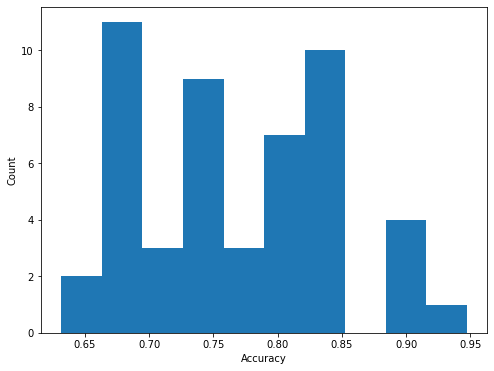

In [14]:
plt.figure(figsize=(8, 6))
plt.hist(test_accs)
plt.xlabel("Accuracy")
plt.ylabel("Count")